In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
pd.set_option('display.max_colwidth',1000)
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from html_table_parser.parser import HTMLTableParser

In [2]:
finwiz_url = 'https://finviz.com/quote.ashx?t='
finwiz_search_url = 'https://finviz.com/search.ashx?p='

# Search for the company's ticker

- give options for the user to input company name or ticker
- try to make the df returned as an input selector

In [3]:
print('===============================================================')
search_term=str(input("Enter company name: "))#'goldman'
search_url=finwiz_search_url+search_term.upper()
print(search_url)
print('===============================================================')

req = Request(url=search_url,headers={'user-agent': 'my-app/0.0.1'})
f = urlopen(req)
xhtml = f.read().decode('utf-8')

p = HTMLTableParser()
p.feed(xhtml)
df=pd.DataFrame(p.tables[5])
df=df.rename(columns=df.iloc[0])[1:][['Ticker','Description']]
print('===============================================================')
print("Search Results for {}:\n".format(search_term))
print(df)
print('===============================================================')
print('===============================================================')
print("Find company ticker")
print('===============================================================')

Enter company name: goldman
https://finviz.com/search.ashx?p=GOLDMAN
Search Results for goldman:

   Ticker                                               Description
1    AAAU                           Goldman Sachs Physical Gold ETF
2    GBIL                Goldman Sachs Access Treasury 0-1 Year ETF
3    GCOR              Goldman Sachs Access U.S. Aggregate Bond ETF
4     GEM      Goldman Sachs ActiveBeta Emerging Markets Equity ETF
5     GER             Goldman Sachs MLP and Energy Renaissance Fund
6    GHYB        Goldman Sachs Access High Yield Corporate Bond ETF
7    GIGB  Goldman Sachs Access Investment Grade Corporate Bond ETF
8    GINN                         Goldman Sachs Innovate Equity ETF
9      GS                             The Goldman Sachs Group, Inc.
10   GSBD                                   Goldman Sachs BDC, Inc.
11   GSEU                Goldman Sachs ActiveBeta Europe Equity ETF
12   GSEW      Goldman Sachs Equal Weight U.S. Large Cap Equity ETF
13   GSIE         

In [4]:
tickers=[]
print('===============================================================')
ticker=str(input("Enter company ticker: ")).upper()
print('===============================================================')
tickers.append(ticker)

Enter company ticker: just


# Start Sentiment Analysis

In [5]:
news_tables = {}

for ticker in tickers:
    url = finwiz_url + ticker
#     print(url)
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    if news_table:
        news_tables[ticker] = news_table
    else:
        print('No Headlines')

In [18]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    if news_table.findAll('tr'):
        for x in news_table.findAll('tr'):
            # read the text from each tr tag into text
            # get text from a only
            text = x.a.get_text() 
            # splite text in the td tag into a list 
            date_scrape = x.td.text.split()
            # if the length of 'date_scrape' is 1, load 'time' as the only element

            if len(date_scrape) == 1:
                time = date_scrape[0]

            # else load 'date' as the 1st element and 'time' as the second    
            else:
                date = date_scrape[0]
                time = date_scrape[1]
            # Extract the ticker from the file name, get the string up to the 1st '_'  
            ticker = file_name.split('_')[0]

            # Append ticker, date, time and headline as a list to the 'parsed_news' list
            parsed_news.append([ticker, date, time, text])

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)
parsed_and_scored_news.sample(5)

,ticker,date,time,headline
15,JUST,Jul-05-18,05:47PM,5 Successful New ETFs of Q2
5,JUST,Jan-29-19,04:07PM,"When stock markets turned turbulent, ESG funds punched above their weight"
9,JUST,Nov-16-18,09:23PM,A Better Approach to ESG?
17,JUST,Jun-14-18,10:27AM,"Goldman, Tudor Jones Team Up On Socially Responsible ETF"
8,JUST,Dec-10-18,10:31AM,Medtronic Named One of America's Best Corporate Citizens in 2018 by Forbes Magazine


In [19]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.sample(5)

,ticker,date,time,headline,neg,neu,pos,compound
17,JUST,2018-06-14,10:27AM,"Goldman, Tudor Jones Team Up On Socially Responsible ETF",0.0,0.777,0.223,0.3182
10,JUST,2018-10-30,04:55PM,An ETF That Has Americas Values in Mind Can Also Outperform,0.0,0.787,0.213,0.4019
12,JUST,2018-09-18,04:58PM,Goldman Launches Smart Beta ETFs at Discount Prices,0.0,0.722,0.278,0.4019
6,JUST,2018-12-10,04:51PM,An ETF to Capitalize on Companies that Prioritize American Workers,0.0,1.000,0.000,0.0000
11,JUST,2018-10-08,09:04AM,This is one way Donald Trump has been good for the environment,0.0,0.791,0.209,0.4404


In [31]:
# Set the index to ticker and date
single_day = parsed_and_scored_news.set_index(['ticker', 'date'])
# Cross-section the tsla row
single_day = single_day.xs(parsed_and_scored_news['ticker'][0])
# Select the 3rd of January of 2019
DATE=str(input("Enter Date (YYYY-MM-DD): "))
if single_day.loc[DATE].shape[0]==0:
    print('Last headline date: ',max(single_day.index).date())
else:
    single_day = single_day.loc[DATE]
    # Convert the datetime string to just the time
    single_day['time'] = pd.to_datetime(single_day['time']).dt.time
    # Set the index to time and sort by it
    single_day = single_day.set_index('time')
    # Sort it
    single_day = single_day.sort_index()


Enter Date (YYYY-MM-DD): 2018-10-08


In [32]:
single_day

,headline,neg,neu,pos,compound
time,,,,,
09:04:00,This is one way Donald Trump has been good for the environment,0.0,0.791,0.209,0.4404


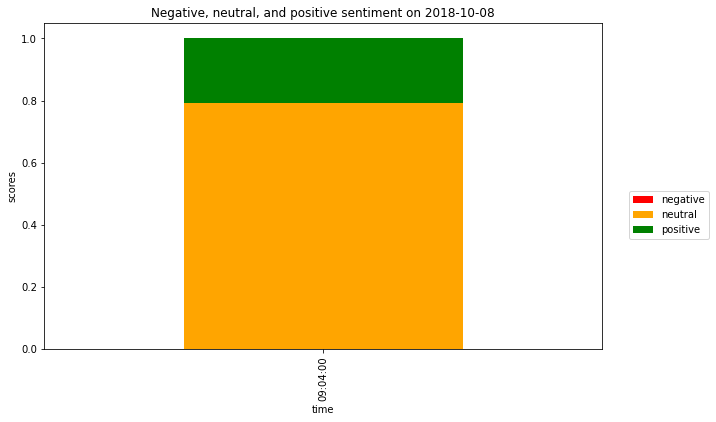

In [33]:
TITLE = "Negative, neutral, and positive sentiment on "+DATE
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['compound', 'headline'], 1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");